In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from utils import pickle_zip,pickle_unzip
import os
PROJ_DIR = "/Users/ayushbhakat/Desktop/sem-5/BDA"
ASRS_DATA = "/Users/ayushbhakat/Desktop/sem-5/BDA/data.csv"
CLEAN_DATA = os.path.join(PROJ_DIR,'raw','asrs_clean.pkl.zip')
ASRS_LABELED_DATA = os.path.join(PROJ_DIR,'data','asrs_cluster_labels.pkl.zip')


: 

### Loads Original ASRS data from Hadoop

In [10]:

class ASRSRawloader:
    def __init__(self, laod_pickle = True, save_pickle = True):
        keepers = ['Make Model Name','Mission','Flight Phase','Problem','Human Factors','Result','Anomaly','Narrative']
        self.data = pd.read_csv(ASRS_DATA,usecols = keepers)
        self.data.dropna(inplace=True)
        self.data['Narrative'] = self.data['Narrative'].str.lower()
        self.data['Narrative'] = self.data['Narrative'].str.replace('; ', ', ')
        self.data['Narrative'] = self.data['Narrative'].str.rstrip('.') + '.' 

        self.data['Flight Phase'] = self.data['Flight Phase'].str.lower()
        self.data['Flight Phase'] = self.data['Flight Phase'].str.replace('; ', ', ')

        self.data['Anomaly'] = self.data['Anomaly'].str.lower()
        self.data['Anomaly'] = self.data['Anomaly'].str.replace('; ', '. ')
        self.data['Anomaly'] = self.data['Anomaly'].str.replace(' / ', ', ')
        self.data['Anomaly'] = self.data['Anomaly'].str.rstrip('.') + '.' 

        self.data['Human Factors'] = self.data['Human Factors'].str.lower()
        self.data['Human Factors'] = self.data['Human Factors'].str.replace('; ', '. ')
        self.data['Human Factors'] = self.data['Human Factors'].str.replace(' / ', ', ')
        self.data['Human Factors'] = self.data['Human Factors'].str.rstrip('.') + '.' 

        self.data['Mission'] = self.data['Mission'].str.lower()
        self.data['Mission'] = self.data['Mission'].str.replace('; ', '. ')
        self.data['Mission'] = self.data['Mission'].str.replace(' / ', ', ')
        self.data['Mission'] = self.data['Mission'].str.rstrip('.') + '.' 

        self.data['Result'] = self.data['Result'].str.lower()
        self.data['Result'] = self.data['Result'].str.replace('; ', ' ')
        self.data['Result'] = self.data['Result'].str.replace(' / ', '.')
        self.data['Result'] = self.data['Result'].str.rstrip('.') + '.' 

        if save_pickle:
            self.save_pickle()
    def save_pickle(self,filename = CLEAN_DATA):
        print('Saving pickle to {}'.format(filename))
        pickle_zip(self.data, filename)
    def __len__(self):
        return self.data.shape[0]
    def get_random_sample(self, count=10):
        return self.data.sample(count).reset_index(drop=True)



# loader = Rawloader()
# loader.data.head()

class MainLoader():
    def __init__(self, pickle_file = 'asrs_cluster_labels.pkl.zip' ):
        self.pickle_file = os.path.join(PROJ_DIR,'Data',pickle_file)
        self.asrs = pickle_unzip(self.pickle_file)
        self.data  =self.asrs.copy()
        print(f'{self.data.shape[0]} ASRS Records Loaded')
    def reduce_columns(self):
        self.data.drop(columns = ['Make Model Name','Mission','Flight Phase','Problem','Human Factors','Anomaly','Result'], inplace=True)
        self.data.rename(columns={'cluster': 'label', 'Narrative': 'text'}, inplace=True)
        self.data['label'] = self.data['label'].astype(np.int64)
        self.data.reset_index(drop=True, inplace=True)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        label = self.data.iloc[idx]['label']
        label = np.array(label).astype(np.float32)
        label = tf.convert_to_tensor(label)
        text = self.data.iloc[idx]['text']
        raw_dict = {'label': label, 'text': text, 'idx': idx}
        return raw_dict



### This Cell consists of a KMeans Clusting script to specifically identify two classes from the raw ASRS Dataset available to us

- Firstly Embeddings are created for each Anomaly using the encoder model 

- The we perform Clustering to create binary classes

- The clusters are visualized using the TSNE Algorithm 

In [4]:

from sklearn.model_selection import train_test_split
from models import get_encoder_model,get_clustering_model
import os

def create_clusters(num_clusters = 2, save_pickle = True):
    asrs = ASRSRawloader()
    corpus = asrs.data
    corpus_sentences = corpus['Result'].tolist()
    print("Embedding the Results. This might take a while ...")
    encoder = get_encoder_model()
    embeddings = encoder.encode(corpus_sentences,batch_size=64,show_progress_bar=True,convert_to_tensor=True)
    corpus_emb = pd.DataFrame(embeddings.cpu())

    # Generate Clusters
    print("Initilizing Clustering")
    print("embeddings",embeddings.cpu().numpy())
    kmeans = get_clustering_model()
    cluster_labels = kmeans.fit(embeddings.cpu().numpy()).labels_
    corpus['cluster'] = cluster_labels
    print("Clustering Complete")
    
    # # store cluster centers in a dataframe
    # cluster_data = pd.DataFrame()
    # cluster_centers = kmeans.cluster_centers_
    # cluster_data['cluster'] = np.arange(num_clusters)
    # cluster_data['centers'] = cluster_centers.tolist()

    if save_pickle:
        print("Saving Pickle files to DATA. ")
        pickle_zip(corpus,ASRS_LABELED_DATA)

        train_data, test_data = train_test_split(corpus, train_size = 0.8, random_state=42)
        pickle_zip(train_data,os.path.join('data','asrs_data_clean_2000_train.pkl.zip'))
        pickle_zip(test_data,os.path.join('data','asrs_data_clean_2000_test.pkl.zip'))
    # # feedback
    # print()
    # print('Corpus shape: ', corpus.shape)
    # print('Cluster Data shape: ', cluster_data.shape)
    # print('Corpus Embeddings shape: ', corpus_emb.shape)
    # print()
    return embeddings,cluster_labels
if __name__ == '__main__':
    embeddings,labels = create_clusters()



/Users/ayushbhakat/Documents/Neurome/venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Saving pickle to /Users/ayushbhakat/Desktop/sem-5/BDA/raw/asrs_clean.pkl.zip
Embedding the Results. This might take a while ...


Batches:   0%|          | 0/211 [00:00<?, ?it/s]

Initilizing Clustering
embeddings [[-0.00848859 -0.00674733 -0.02136626 ... -0.01853766 -0.07495442
   0.01883467]
 [-0.00073785 -0.01761357  0.0364076  ... -0.09881049 -0.0533882
   0.02697086]
 [-0.01429764 -0.02981802  0.01631297 ... -0.06709884 -0.05324144
   0.01393339]
 ...
 [ 0.02091851 -0.02335948 -0.03868201 ... -0.0391832   0.01535822
   0.02577814]
 [ 0.0104523   0.00398308 -0.01734151 ... -0.032652   -0.00637906
   0.02248377]
 [-0.03215256 -0.01818768  0.013026   ... -0.04214146 -0.02119179
  -0.00158801]]
Clustering Complete
Saving Pickle files to DATA. 


### PLOTTING CLUSTERS

[0 1]
Plotting 5000 points ...


/Users/ayushbhakat/Documents/Neurome/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ayushbhakat/Documents/Neurome/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


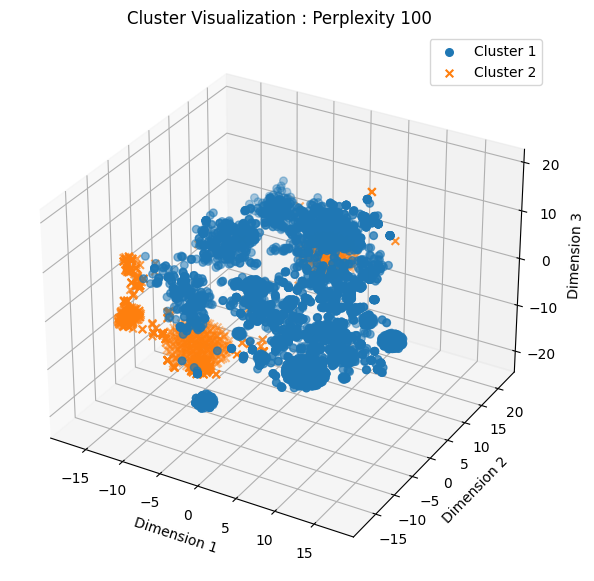

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_clusters(embeddings,labels, num_clusters=2,perplex = 100, n_iter= 500, show = False, count = 5000):
    embeddings = embeddings[:count]
    labels = labels[:count]
    print(f"Plotting {labels.shape[0]} points ...")
    reducer = TSNE(n_components=3, perplexity = perplex)
    reduced_embeddings = reducer.fit_transform(embeddings)

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111,projection='3d')

    markers = ['o','x','*','^']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    # Iterate over each cluster and plot the points with corresponding markers and colors
    for i in range(num_clusters):
        points_in_cluster = reduced_embeddings[labels == i]
        ax.scatter(
            points_in_cluster[:, 0],
            points_in_cluster[:, 1],
            points_in_cluster[:, 2],
            marker=markers[i % len(markers)],  # Cycle through markers if more clusters than markers
            color=colors[i % len(colors)],  # Cycle through colors if more clusters than colors
            s=30,  # Adjust the size of the points as per your preference
            label=f'Cluster {i+1}'
        )

    ax.set_title('Cluster Visualization : Perplexity {}'.format(perplex))
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.legend()
    plt.show()
print(np.unique(labels))
plot_clusters(embeddings.cpu().numpy(),labels)

In [12]:
loader = MainLoader()
loader.data[loader.data['cluster']==1]
df = loader.data
df.to_csv('data1.csv',index = False)



13441 ASRS Records Loaded


In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session with Hive support and configurations
spark = SparkSession.builder \
    .appName("AirCrashInvestigation") \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://localhost:9083") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

# Read data from Hive table into DataFrame
try:
    # First, set the database
    spark.sql("USE air_crash_investigation")
    
    # Then query the table
    aadf = spark.sql("""
        SELECT 
            Make_Model_Name,
            Mission,
            Flight_Phase,
            Problem,
            Human_Factors,
            Anomaly,
            Result,
            Narrative,
            cluster
        FROM CleanedData
    """)
    
    # Convert to Pandas DataFrame
    df = aadf.toPandas()
    
    print("DataFrame Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())

except Exception as e:
    print("Error occurred:", str(e))

finally:
    spark.stop()

24/10/23 09:43:23 WARN Utils: Your hostname, vortex-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/10/23 09:43:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/23 09:43:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/23 09:43:47 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/10/23 09:43:56 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


DataFrame Shape: (13442, 9)

First few rows:
       Make_Model_Name     Mission      Flight_Phase         Problem  \
0      Make Model Name     Mission      Flight Phase         Problem   
1  B767-300 and 300 ER  passenger.  takeoff / launch  Malfunctioning   
2             B767-200  passenger.     initial climb          Design   
3                 A320  passenger.           descent          Design   
4                 A330  passenger.            cruise  Malfunctioning   

                                     Human_Factors  \
0                                    Human Factors   
1                                       confusion.   
2                         time pressure. workload.   
3                           situational awareness.   
4  human-machine interface. situational awareness.   

                                             Anomaly  \
0                                            Anomaly   
1    "aircraft equipment problem critical. deviation   
2  "aircraft equipment proble

## BDA MODEL CREATION

In [52]:
import tensorflow as tf
import numpy as np
# import tensorflow_addons as tfa
from transformers import TFAutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# df = loader.data
# df = df[:5000]
# Encode categorical Features
categorical_features = ['Make Model Name', 'Mission', 'Flight Phase', 'Problem', 'Human Factors', 'Anomaly']
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# Split Data
X = df[['Make Model Name', 'Mission', 'Flight Phase', 'Problem', 'Human Factors', 'Anomaly', 'Narrative']]
y = df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre_trained model and tokenizer 
model_name = "distilbert-base-uncased"
base_model = TFAutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#LoRA layer Implementation

class LoRALayer(tf.keras.layers.Layer):
    def __init__(self,in_features, out_features, rank=4, alpha=32):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha

        self.A = self.add_weight(shape=(in_features, rank),
                                 initializer = 'random_normal',
                                 trainable = True,
                                 name='Lora_A')
        self.B = self.add_weight(shape=(rank, out_features),
                                 initializer = 'random_normal',
                                 trainable = True,
                                 name = 'Lora_B')
        self.scaling = self.alpha/self.rank
    def call(self,x):
        return tf.matmul(tf.matmul(x, self.A), self.B) * self.scaling

# Custom Attention Layer with LoRA

class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units
        self.query = tf.keras.layers.Dense(units)
        self.key = tf.keras.layers.Dense(units)
        self.value = tf.keras.layers.Dense(units)
        self.lora_query = LoRALayer(units, units)
        self.lora_value = LoRALayer(units, units)

    def call(self, inputs):
        query = self.query(inputs)+self.lora_query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)+self.lora_value(inputs)
        attention = tf.matmul(query, key, transpose_b=True)
        attention = tf.nn.softmax(attention, axis=-1)
        output = tf.matmul(attention, value)
        return output       

class FeatureImportanceLayer(tf.keras.layers.Layer):
    def __init__(self, num_features):
        super().__init__()
        self.importance = self.add_weight(shape=(num_features,),
                                    initializer='ones',
                                    trainable=True,
                                    name='feature_importance')
    def call(self, inputs):
        return inputs * self.importance
class HuggingFaceModelWrapper(tf.keras.layers.Layer):
    def __init__(self, base_model):
        super(HuggingFaceModelWrapper, self).__init__()
        self.base_model = base_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.base_model(input_ids=input_ids, attention_mask=attention_mask)[0]
    
def create_model(base_model, num_classes, num_features):
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name = "input_ids")
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
    feature_inputs = tf.keras.layers.Input(shape=(num_features,), dtype=tf.float32, name='feature_inputs')
    outputs = HuggingFaceModelWrapper(base_model)([input_ids, attention_mask])
    # custom attention
    custom_attention = CustomAttention(base_model.config.hidden_size)
    attention_output = custom_attention(outputs)
    # Feature importance
    feature_importance = FeatureImportanceLayer(num_features)(feature_inputs)
    # Combine Text and Feature outputs
    combined = tf.keras.layers.Concatenate()([attention_output[:,0,:],feature_importance])
    # final classification layers
    x = tf.keras.layers.Dense(128, activation = 'relu')(combined)
    x = tf.keras.layers.Dropout(0.01)(x)
    x = tf.keras.layers.Dense(64, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.01)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_ids, attention_mask, feature_inputs], outputs=outputs)
    return model

# Creating and compiling the model

num_classes = len(df['cluster'].unique())
num_features = len(categorical_features)
model = create_model(base_model, num_classes, num_features)
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4,weight_decay = 0.01),loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Prepairing data for training

def prepare_inputs(X,tokenizer, max_length = 120):
    texts = X['Narrative'].tolist()
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
    feature_inputs = X[categorical_features].values
    print(encodings['input_ids'].shape)
    print(encodings['attention_mask'].shape)
    return [encodings['input_ids'], encodings['attention_mask'], feature_inputs]

X_train_inputs = prepare_inputs(X_train, tokenizer)
X_test_inputs = prepare_inputs(X_test, tokenizer)

# Train the model
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# history = model.fit(
#     X_train_inputs, y_train,
#     validation_data=(X_test_inputs, y_test),
#     epochs=12,
#     batch_size=64
# )
# model.save(os.path.join(PROJ_DIR,'model','model1'))
# pickle_zip(history,os.path.join(PROJ_DIR,'model','history','h1.pkl.zip'))



/var/folders/ly/rmmmtc692fq6ttztrpqwgpcr0000gn/T/ipykernel_1331/1338488123.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.fit_transform(df[feature])
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 hugging_face_model_wrapper  (None, None, 768)            6636288   ['input_ids[0][0]',           
 _6 (HuggingFaceModelWrappe                               0          'attention_mask[0][0]']      
 r)                                                                                         

## Back Tracking and Explainable AI

In [72]:

# Function to get feature importance
def get_feature_importance(model):
    feature_importance_layer = [layer for layer in model.layers if layer.name == 'feature_importance_layer_1'][0]
    return feature_importance_layer.importance.numpy()

def find_custom_attention_layer(model, layer_type):
    for layer in model.layers:
        if isinstance(layer, layer_type):
            return layer
        # If it's a model or contains sub-layers, search inside
        if hasattr(layer, 'layers'):
            sub_layer = find_custom_attention_layer(layer, layer_type)
            if sub_layer is not None:
                return sub_layer
    return None


# Function for backtracking
def backtrack_prediction(model, input_text, feature_values):
    # Tokenize input
    encodings = tokenizer(input_text, truncation=True, padding=True, max_length=128, return_tensors='tf')
    feature_inputs = np.array([feature_values])
    
    # Get model prediction
    prediction = model.predict([encodings['input_ids'], encodings['attention_mask'], feature_inputs])
    predicted_class = np.argmax(prediction[0])
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                           outputs=model.get_layer('hugging_face_model_wrapper_1').output)
    layer3_output = intermediate_layer_model([encodings['input_ids'], encodings['attention_mask'],feature_inputs])
    # for layer in model.layers:
    #     print(layer.name)
    #     print(isinstance(layer,CustomAttention))
    # Get attention weights
    attention_layer = [layer for layer in model.layers if layer.name =='custom_attention_1'][0]
    attention_weights = attention_layer(layer3_output)[0]
    
    # Get most important words
    important_word_indices = tf.argsort(tf.reduce_sum(attention_weights, axis=1), direction='DESCENDING')[:5]
    important_word_ids = tf.gather(encodings['input_ids'][0], important_word_indices)
    important_words = tokenizer.convert_ids_to_tokens(important_word_ids.numpy())    
    # Get feature importance
    feature_importance = get_feature_importance(model)
    important_features = sorted(zip(categorical_features, feature_importance), key=lambda x: x[1], reverse=True)[:3]
    
    return predicted_class, important_words, important_features

## Creating an LLM to provide a description for the predicted class

In [75]:
from langchain_groq import ChatGroq
from langchain import PromptTemplate, LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
import sys
from dotenv import load_dotenv
load_dotenv()
model = tf.keras.models.load_model('/Users/ayushbhakat/Desktop/sem-5/BDA/model/model1')
# model.summary()
sys.path.append('/Users/ayushbhakat/Desktop/sem-5/BDA')
groq_api_key = os.environ['GROQ_API_KEY']
llama = ChatGroq(groq_api_key = groq_api_key,
               model_name="Llama3-8b-8192")

prompt = """
        Based on the following information:
        - Input text: {input_text}
        - Predicted cluster: {cluster}
        - Important words: {important_words}
        - Important features: {important_features}

        Provide a detailed explanation of why this input was classified into the given cluster. 
        Highlight the key factors that influenced the decision and explain how they relate to the cluster characteristics.
        """
prompt_template = ChatPromptTemplate.from_template(prompt)


llm_chain = (
    {
        "input_text":itemgetter('input_text'),
        "cluster":itemgetter('cluster'),
        "important_words":itemgetter('important_words'),
        "important_features":itemgetter('important_features'),
    }
    |
    prompt_template
    |
    llama
    |
    StrOutputParser()
)
def generate_explanation(input_text, feature_values):
    predicted_class, important_words, important_features = backtrack_prediction(model, input_text, feature_values)
    cls = lambda x: "CRITICAL" if x == 0 else "NOT CRITICAL"
    explanation = llm_chain.invoke({"input_text":input_text,"cluster":cls(predicted_class),"important_words":important_words,"important_features":important_features})
    return predicted_class,explanation

# Example usage
input_text = "Aircraft experienced engine failure during takeoff. It caused it to crash and disintegrate"
feature_values = [0, 1, 0, 2, 1, 1]  # Example values for categorical features
predicted_class,explanation = generate_explanation(input_text, feature_values)
print("Prediction states that the condition is : ","critical" if predicted_class == 0 else "not critical")
print(explanation)


1/1 [==============================] - 4s 4s/step
Prediction states that the condition is :  critical
Based on the provided information, the input text "Aircraft experienced engine failure during takeoff. It caused it to crash and disintegrate" was classified into the CRITICAL cluster. Here's a detailed explanation of the key factors that influenced this decision:

1. **Important words**: The presence of words like 'crash', 'engine', 'failure', and 'during' in the input text suggests a catastrophic event, which is a characteristic of the CRITICAL cluster. These words are indicative of a severe and unexpected incident that has significant consequences.
2. **Context**: The context of the text, specifically the mention of takeoff and engine failure, implies a critical phase of flight. Takeoff is a high-risk phase, and engine failure during this phase can lead to a loss of control and subsequent crash.
3. **Important features**: The feature 'Flight Phase' has the highest weightage (1.00929